# Grover's algorithm

In this notebook, we are presenting the application of the Grover's algorithm interpreted as a coined search on a complete graph. 

We considere a graph with N verticles where each vertex has every other verticles (including itslef) as a neighbor. The vertex are labelled 1, ... , N. 
The coin space is N-dimensional and $\left|\psi _c\right\rangle =  \left|i\right\rangle $ , which means that the direction of the coin is the ith vertex. 

The shift operation S is defined as $S\left|i\right\rangle \left|j\right\rangle = \left|j\right\rangle \left|i\right\rangle $. So $S = SWAP$



#### References :
- Ambainis, A., Kempe, J., Rivosh, A. (2005): Coins make quantum walks faster.
- Portugal, R. (2019). Quantum Walks and Search Algorithms - Second Edition (Softcover reprint of the original 2nd ed. 2018 éd.). Springer.
- Qiskit.org. (2021, 17 novembre). Grover’s Algorithm. https://qiskit.org/textbook/ch-algorithms/grover.html

In [1]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

/home/jlucas/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Useful gates

In [18]:
def reflection(n, sol, v= False):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    reflection = Diagonal(diagonal_elements)
    reflection.name = "$O$"
    if v : 
        print('O = Diag ', diagonal_elements)
        print(reflection)
    return reflection.to_gate()

# phase flip of the index 5 among 8 elements (0 to 7)
reflection(3, 5, v= True)

O = Diag  [1, 1, 1, 1, 1, -1, 1, 1]
     ┌───────────┐
q_0: ┤0          ├
     │           │
q_1: ┤1 Diagonal ├
     │           │
q_2: ┤2          ├
     └───────────┘


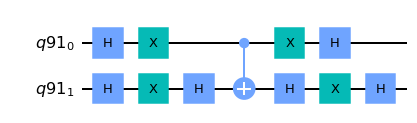

In [13]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr, name = '$C_{Diff}$')
    
    # The diffuseur coin is the reflection around |s> = 2^(-n) Σ_i=1..2^n |i> (superposition state of all directions)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser
# The 2-dimension diffusion coin
diffuser(2).draw(output ='mpl')

## Useful functions

In [4]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [5]:
def grover_dec_bar(n,counts, m=0):
    t= 2**(n)
    x= range(t)
    y= [0]*t
    for num in list(counts.keys()) :
        no = int(num[m:], base = 2)
        #print(no)
        y[no]+= counts[num]
    y = np.array(y)/sum(y)

    plt.bar(x,y)

## Grover's coined version

We applie 

$U'=S \cdot C' = C_0\otimes (I-2\left|v\right\rangle \left\langle v \right|)$ 

(the marked coin $C_1$ is chosen as $C_1 = -C_0$)

to the initial state :

$\left|\psi _0\right\rangle = H^n\left|0\right\rangle^n  $

where :

$\left|v\right\rangle$ is the marked verticle

$C_0 = \begin{pmatrix}
\frac{2}{n}-1  & \frac{2}{n} & ... & \frac{2}{n} \\
\frac{2}{n}  & \frac{2}{n}-1 & ... & \frac{2}{n} \\
... & ... & ... & ... \\
\frac{2}{n}  & \frac{2}{n} & ... & \frac{2}{n}-1  
\end{pmatrix}$ is the grover's diffusion operator

$S=SWAP$ is the shift gate


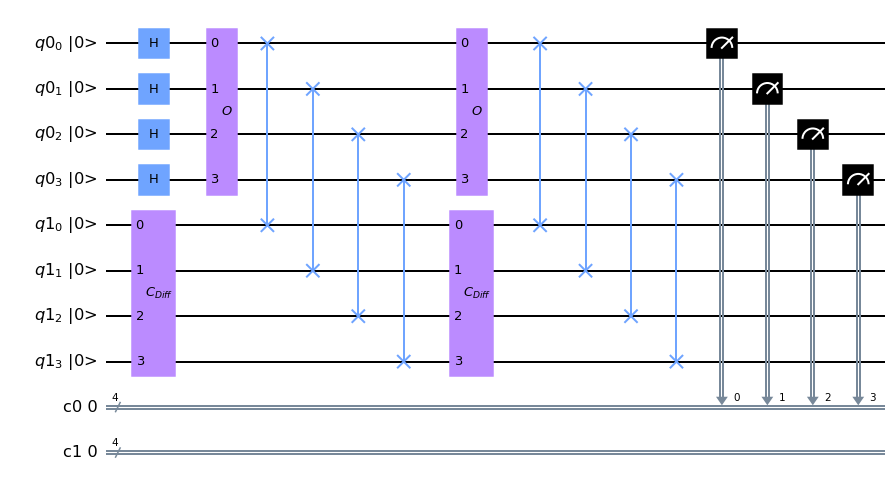

In [6]:
n=4
i = 3


qr = QuantumRegister(n)
qc = QuantumRegister(n)

cr = ClassicalRegister(n)
cc = ClassicalRegister(n)

circuit = QuantumCircuit(qr, qc , cr, cc)


circuit.h(qr[:])


oracle = reflection(n, i)
circuit.append(oracle,  qr[:] )


diffuseur = diffuser(n)
circuit.append(diffuseur, qc[:])

circuit.swap(qc[:],qr[:])

circuit.append(oracle,  qr[:] )


circuit.append(diffuseur, qc[:])

circuit.swap(qc[:],qr[:])


circuit.measure(qr[:] , cr[:] )

circuit.draw(output ='mpl', initial_state= True, filename ='grover_coin.png')

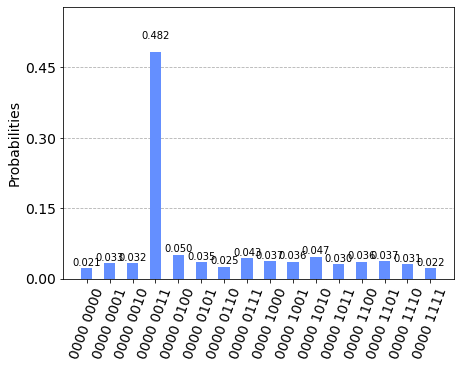

In [7]:
counts = simulate(circuit)
plot_histogram(counts)

Text(0, 0.5, 'probabilities')

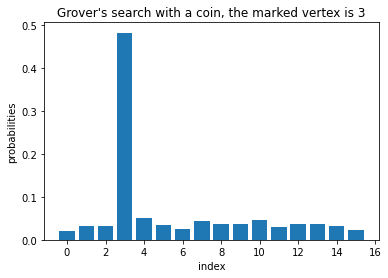

In [8]:
grover_dec_bar(n,counts,n+1)
plt.title("Grover's search with a coin, the marked vertex is "+str(i))
plt.xlabel('index')
plt.ylabel('probabilities')
#plt.savefig('output_grover.png')

## Grover's classical algorithm

This is the classical grover's algorithm

$G= D_{iffusion} \cdot O_{racle}$

applied to the initial state :



$\left|\psi _0\right\rangle = H^n\left|0\right\rangle^n  $


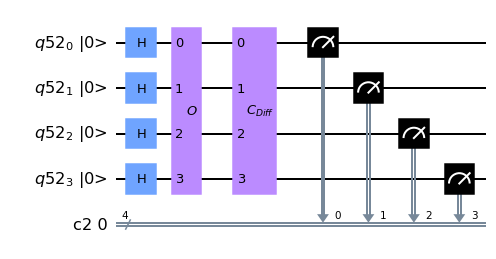

In [9]:
n=4
i = 4

qr = QuantumRegister(n)
cr = ClassicalRegister(n)


circuit = QuantumCircuit(qr , cr)

circuit.h(qr[:])

oracle = reflection(n, i)
circuit.append(oracle,  qr[:] )

diffuseur = diffuser(n)
circuit.append(diffuseur, qr[:])

circuit.measure(qr, cr)

circuit.draw(output ='mpl',  filename ='Grover.png', initial_state= True)

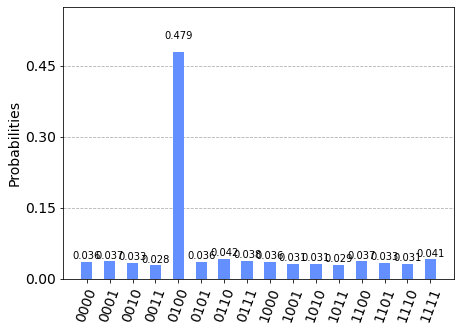

In [10]:
counts = simulate(circuit)
plot_histogram(counts)

Text(0, 0.5, 'probabilities')

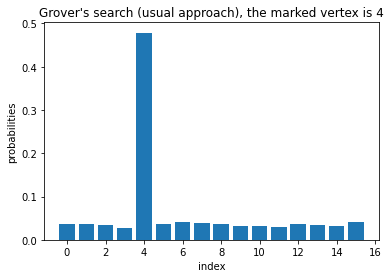

In [11]:
grover_dec_bar(n,counts)
plt.title("Grover's search (usual approach), the marked vertex is "+str(i))
plt.xlabel('index')
plt.ylabel('probabilities')

## Conclusion : 

The two circuits are equivalent thanks to the $SWAP$ gate. Indeed the resulting computation on the position register is applying the reflection gate (equivalent to the oracle) and the diffusion gate. Both algoritms have the same query complexity in $\sqrt{N}$ but the coined version has yet twice as much operations.